**概述**：

+ 使用IMDB评论数据集，其中包含来自互联网电影数据库的5w条影评文本，分为了2.5w训练集和2.5w测试集。
+ 训练集和测试机是平衡的，即其中包含相同数量的正面影评和负面影评
+ 二分类

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_data,train_labels),(test_data,test_labels)=keras.datasets.imdb.load_data(num_words=10000)

keras.datasets.imdb.load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs)

可以看到这个函数是有默认路径的，可以去这个imdb的load_data去看看，因为这里还有num_words的限制，注意这个数据集是英语的，所以不需要分词，统计个数就好了.

参数num_words=10000,保留训练数据中出现频次在前1w的词，为确保数据规模处于可管理的水平，罕见字词将会被舍弃

In [3]:
train_data.shape,train_labels.shape

((25000,), (25000,))

In [4]:
len(train_data[1]),train_labels[:3],len(train_data[2])

(189, array([1, 0, 0], dtype=int64), 141)

train_data已经被处理成了数字序号列表，但是列表长度并不一致，下面会对此进行处理。二分类是 0（负面）,1（正面）

## 将整数转回字词

In [5]:
word_index=keras.datasets.imdb.get_word_index()  

直接执行上面那句，会显示

Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json

然后报错，时间超时，无法下载。。如法炮制昨天的做法，迅雷下载，然后把东西放到那个文件夹下。

keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

可以看到都有一个默认的path值，就是相对~/.keras/datasets这个路径的路径

In [6]:
word_index={k:(v+3) for k,v in word_index.items()} #空出三个是为了填充一些别的东西
word_index['<PAD>']=0
word_index['<START>']=1
word_index['<UNK>']=2 #unknown
word_index['<UNUSED>']=3
#上面是 词 到 num
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
# reverse_word_index={value:key for key,value in word_index.items()}  
#这种写法和上面效果差不多，但是比上面简单，虽然不明白为什么没采用这个

    print(reverse_word_index[1])
    reverse21_word_index={value:key for key,value in word_index.items()}
    print(reverse21_word_index[1])

In [7]:
def decode_review(text):
    return(' '.join([reverse_word_index.get(i,'?') for i in text]))

D.get(k[,d]) -> D[k] if k in D, else d.  d defaults to None.

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据

影评数据必须转换为张量，然后才能馈送到神经网络中，可以通过以下两种方式实现：（所以使用独热码或者数字序号表示都只是数据处理的一种方式，二者是相斥的）

+ 1. 使用独热码编码。比如，序列[3,5]会变成一个1w维的向量，（上面num_words是1w），除了索引3和5转为1之外，其余全转换为0。然后，将它作为网络的第一层，一个可以处理浮点向量数据的密集层。不过这种方法会占据大量内存，需要一个大小为num_words\*num_reviews的矩阵
+ 2. 或者，我们可以填充数组，使它们具有相同的长度，然后创建一个形状为max_length\*num_reviews的整数张量，可以使用一个能够处理这种形状的嵌入层作为网络中的第一层

+ 这个教程中，使用第二种方式。要保证影评数据长度相同，所以使用pad_sequences函数将长度标准化

    sequences: List of lists, where each element is a sequence.
    maxlen: Int, maximum length of all sequences.
    dtype: Type of the output sequences.
        To pad sequences with variable length strings, you can use `object`.
    padding: String, 'pre' or 'post':
        pad either before or after each sequence.
    truncating: String, 'pre' or 'post':
        remove values from sequences larger than
        `maxlen`, either at the beginning or at the end of the sequences.
    value: Float or String, padding value.

In [9]:
maxlen=256
train_data=keras.preprocessing.sequence.pad_sequences(train_data,
                                                      maxlen=maxlen,
                                                      padding='post',  #在后面填充
                                                      value=word_index['<PAD>']
                                                     )
test_data=keras.preprocessing.sequence.pad_sequences(test_data,
                                                      maxlen=maxlen,
                                                      padding='post',  
                                                      value=word_index['<PAD>']
                                                     )

In [10]:
len(train_data[0]),len(test_data[0])

(256, 256)

In [11]:
print(train_data[0])  #可以看到确实是在后面填充0

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 构建网络

神经网络通过堆叠层创建而成，主要是要决定两个方面的架构：

+ 要在模型中使用多少层
+ 要针对每个层使用多少个隐藏单元

本实例中，输入数据由字词-索引数组构成，要预测的标签是0或1

+ 第一层是Embedding层，它会在 整数编码的词汇表（字词-整数id） 中查找每个 字词-索引的嵌入向量，模型在接受训练时会学习这些向量，这些向量会像输出数组添加一个维度。生成的维度为：（batch,sequence,embedding）
    + 每次输入模型的是一个batch大小的矩阵，其实衣服的10分类也是有batch_size的，只是直接用了默认值32
    + 所以这里输入到下一层的维度是 （16，256，embedding）
    +  input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
    +  output_dim: int >= 0. Dimension of the dense embedding.
 
+ 接下来，使用GlobalAveragePooling1D层对序列维度求平均值，针对每个样本返回一个长度固定的输出向量，这样，模型便能够以尽可能简单的方式处理各种长度的输入。这里没有看到什么默认的steps值。每个词经过嵌入层，都变成了一个16d表示的向量，一共1w个词，所以训练参数就是1w6k
    
    Global average pooling operation for temporal data.
    Arguments:
      data_format: A string,
          one of `channels_last` (default) or `channels_first`.
          The ordering of the dimensions in the inputs.
          `channels_last` corresponds to inputs with shape
          `(batch, steps, features)` while `channels_first`
          corresponds to inputs with shape
          `(batch, features, steps)`.

    Input shape:
        - If `data_format='channels_last'`:
            3D tensor with shape:
            `(batch_size, steps, features)`
        - If `data_format='channels_first'`:
            3D tensor with shape:
            `(batch_size, features, steps)`

    Output shape:
        2D tensor with shape:
        `(batch_size, features)`
+ 最后一层与单个输出节点全连接，使用sigmoid激活函数后，结果是介于0-1之间的浮点数，表示概率或者置信水平

In [12]:
vocab_size=10000

model=keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,16)) 
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


**隐藏单元**：

+ 输入输出之间的层就是隐藏层，如果模型有更多的隐藏单元（更高的表示维度空间）或者更多层，说明网络可以学习更复杂的表示法。不过这将耗费网络大量的计算资源，同时可能导致学习到不需要的模式（能优化训练集上的表现，但不会优化测试集的表现），这称为过拟合。

**损失函数和优化器**：

+ 模型在训练时需要一个损失函数和一个优化器，由于这是一个二分类问题，同时模型会输出一个概率（应用S型激活函数的单个单元层），因此将使用binary_crossentropy损失函数
+ 该函数并不是唯一的损失函数，也可以使用mean_squared_error，但一般来说，binary_crossentropy更适合处理概率问题，它可以测量概率分布之间的‘差距’，在本例中则为实际分布和预测之间的差距
+ 在探索回归问题时（例如房价预测），一般使用另一个称为均方误差的损失函数

In [13]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

## 创建验证集

在训练时，需要检查 模型处理从未见过的数据 的准确率。所以需要创建验证集（从训练集中选一部分作为验证集，只打算使用训练数据开发和调整模型）

In [17]:
x_val=train_data[10000:]
partial_x_train=train_data[:10000]

y_val=train_labels[10000:]
partial_y_train=train_labels[:10000]  

#取前1w的记录作为验证集，剩下的是真的用于训练的训练集

## 训练模型

每次向模型投入512个样本，一共执行大约15000/512次，然后循环40次

In [18]:
history=model.fit(partial_x_train,
                 partial_y_train,
                 epochs=40,
                 batch_size=512,
                 validation_data=(x_val,y_val),
                 verbose=1)

Train on 10000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
10000/10000 [==============================] - 1s 142us/sample - loss: 0.6921 - acc: 0.5059 - val_loss: 0.6907 - val_acc: 0.5085
Epoch 2/40
10000/10000 [==============================] - 1s 82us/sample - loss: 0.6886 - acc: 0.6111 - val_loss: 0.6867 - val_acc: 0.5557
Epoch 3/40
10000/10000 [==============================] - 1s 83us/sample - loss: 0.6830 - acc: 0.6169 - val_loss: 0.6799 - val_acc: 0.7017
Epoch 4/40
10000/10000 [==============================] - 1s 88us/sample - loss: 0.6738 - acc: 0.7281 - val_loss: 0.6690 - val_acc: 0.7273
Epoch 5/40
10000/10000 [==============================] - 1s 83us/sample - loss: 0.6600 - acc: 0.7594 - val_loss: 0.6538 - val_acc: 0.7713
Epoch 6/40
10000/10000 [==============================] - 1s 83us/sample - loss: 0.6410 - acc: 0.7917 - val_loss: 0.6342 - val_acc: 0.7745
Epoch 7/40
10000/10000 [==============================] - 1s 82us/s

In [19]:
loss,acc=model.evaluate(test_data,test_labels)

25000/25000 [==============================] - 1s 27us/sample - loss: 0.3163 - acc: 0.8704


In [20]:
loss,acc

(0.3162978122329712, 0.8704)

## 创建准确率和损失随时间变化的图

model.fit()会返回一个history对象，该对象包含一个字典，其中保存了训练期间所有的指标变化.

这个字典的4个keys对应训练和验证期间的4个受监控指标，可以用这些指标绘制训练损失和验证损失来对比，包括两种准确率对比

In [21]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [22]:
import matplotlib.pyplot as plt

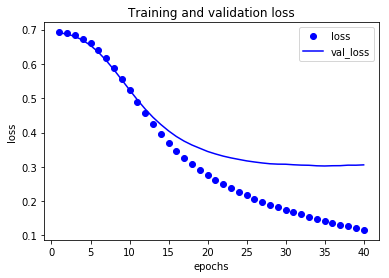

In [26]:
acc=history.history['acc']  #print一下可以知道，其实这里保存的就是每个epochs的acc，列表形式
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1) 

#bo blue dot 
plt.plot(epochs,loss,'bo',label='loss')
# b  blue solid line default
plt.plot(epochs,val_loss,'b',label='val_loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

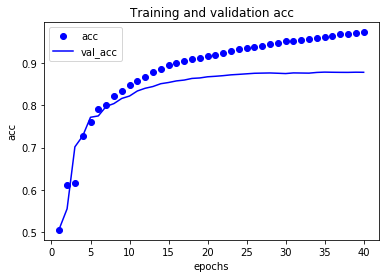

In [27]:
plt.clf() #clear figure 清除图片
plt.plot(epochs,acc,'bo',label='acc')
# b  blue solid line default
plt.plot(epochs,val_acc,'b',label='val_acc')
plt.title('Training and validation acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()

在上面两个图中，圆点表示训练集的损失和准确率，实线表示验证的损失和准确率。

可以注意到，

+ 训练损失随着周期数增加而降低，训练准确率随着周期数增加提高，
    + 在使用梯度下降方法优化模型时，这属于正常现象——该方法在每次迭代时尽可能降低目标值。
+ 但是验证集的损失和准确率变化并不如此，似乎在20周期之后达到峰值。
    + 这是一种过拟合现象：模型在训练数据上的表现要优于在没见过的数据上的表现。这样导致模型过度优化和学习特定于训练数据的表示法，而泛化到其他数据的能力很差。
    + 所以针对这种情况，我们可以在大约20周期后停止U型你连，防止出现过拟合，这可以通过使用回调函数自动执行。